In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# r2o1 ==> Balanced data thru embeddings, cleaned (stopwords not removed) and sentiment added

#Load the dataset (assuming it is in the same location as the notebook)
#data_r2o1_partialclean = pd.read_csv("data_r2o1_partialclean.csv")

# **Adding Sentiment Feature**

In [ ]:

# Create a new DataFrame with the selected features
r2o1_lstm_data = data_r2o1_partialclean.copy()

# Add the 'sentiment' feature based on the mapping logic
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating == 3:
        return "neutral"
    elif rating in [4, 5]:
        return "positive"

r2o1_lstm_data['sentiment'] = r2o1_lstm_data['reviews.rating'].apply(map_sentiment)

In [ ]:
# Verify the new dataset
print("First rows of the new dataset r2o1_lstm_data:")
print(r2o1_lstm_data.head())

First rows of the new dataset r2o1_lstm_data:
                                        reviews.text  reviews.rating sentiment
0                                          dangerous             1.0  negative
1  what a horrendous product i thought that being...             1.0  negative
2  absolutely the worst batteries ive ever used a...             1.0  negative
3                                          dont last             1.0  negative
4                      not much power in these batts             1.0  negative


In [ ]:
# Check the shape of the new datasets
print(f"\nNew dataset r2o1_lstm_data shape: {r2o1_lstm_data.shape}")


New dataset r2o1_lstm_data shape: (6339, 3)


In [ ]:
# Distribution of the 'sentiment' feature
print("\nDistribution of 'sentiment':")
print(r2o1_lstm_data['sentiment'].value_counts())


Distribution of 'sentiment':
sentiment
positive    3000
negative    1839
neutral     1500
Name: count, dtype: int64


In [ ]:
# Save the datasets for r2o1
r2o1_lstm_data.to_csv("r2o1_lstm_dataset.csv", index=False)
print("Sentiment labels assigned and dataset saved for r2o1_lstm_data.")

Sentiment labels assigned and dataset saved for r2o1_lstm_data.


C:\Users\larry\AppData\Local\Temp\ipykernel_14976\449655814.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=r2o1_lstm_data, palette='pastel', order=["negative", "neutral", "positive"])


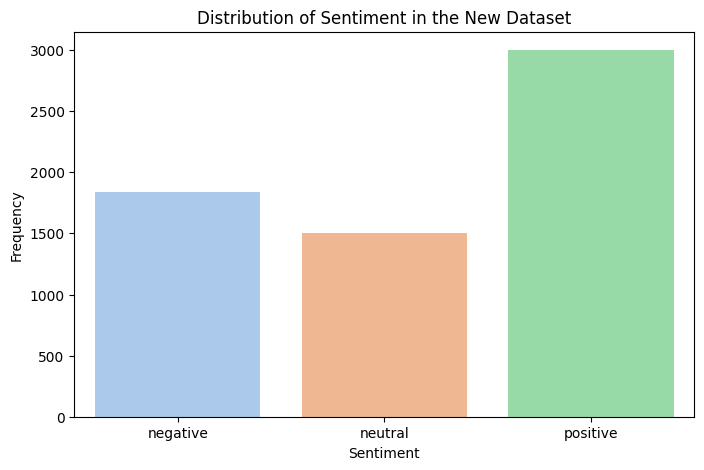

In [ ]:
# Visualize the sentiment distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=r2o1_lstm_data, palette='pastel', order=["negative", "neutral", "positive"])
plt.title("Distribution of Sentiment in the New Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()


# **Splitting the Datasets into train, validation, and test sets.**

In [ ]:
from sklearn.model_selection import train_test_split

# Function to split the dataset with sentiment into train, validation, and test sets
def split_dataset(dataset, stratify_col='sentiment'):
    # Split into train (70%) and temp (30%) for validation and test
    train, temp = train_test_split(dataset, test_size=0.3, random_state=42, stratify=dataset[stratify_col])
    # Further split temp into validation (15%) and test (15%)
    validation, test = train_test_split(temp, test_size=0.5, random_state=42, stratify=temp[stratify_col])
    return train, validation, test

# Split the `r2o1_lstm_data`
print("Splitting `r2o1_lstm_data` into train, validation, and test sets...")
train_r2o1_lstm, val_r2o1_lstm, test_r2o1_lstm = split_dataset(r2o1_lstm_data)
# Verify the sizes of the splits
print(f"Train, validation, and test sizes for `r2o1_lstm_data`: {train_r2o1_lstm.shape}, {val_r2o1_lstm.shape}, {test_r2o1_lstm.shape}")

Splitting `r2o1_lstm_data` into train, validation, and test sets...
Train, validation, and test sizes for `r2o1_lstm_data`: (4437, 3), (951, 3), (951, 3)


In [ ]:
# Save the splits for future use
train_r2o1_lstm.to_csv("train_r2o1_lstm.csv", index=False)
val_r2o1_lstm.to_csv("val_r2o1_lstm.csv", index=False)
test_r2o1_lstm.to_csv("test_r2o1_lstm.csv", index=False)

print("\nDataset splits saved successfully!")


Dataset splits saved successfully!


In [ ]:
# Load the spitted datasets (assuming it is in the same location as the notebook)
train_r2o1_lstm = pd.read_csv("train_r2o1_lstm.csv")
val_r2o1_lstm = pd.read_csv("val_r2o1_lstm.csv")
test_r2o1_lstm = pd.read_csv("test_r2o1_lstm.csv")


# **Data Balancing Check**


Class distribution for train_r2o1_lstm before balancing:
sentiment
positive    2100
negative    1287
neutral     1050
Name: count, dtype: int64


<ipython-input-3-c78789b4916e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=train_r2o1_lstm, palette='pastel', order=["negative", "neutral", "positive"])


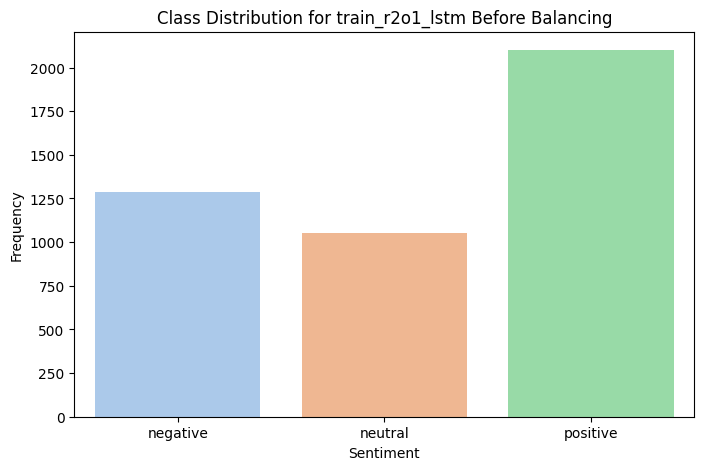

In [ ]:
# Check the class distribution
print("\nClass distribution for train_r2o1_lstm before balancing:")
class_counts_v03 = train_r2o1_lstm['sentiment'].value_counts()
print(class_counts_v03)

# Visualize the class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=train_r2o1_lstm, palette='pastel', order=["negative", "neutral", "positive"])
plt.title("Class Distribution for train_r2o1_lstm Before Balancing")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()

# **Models Training and Evaluation**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [ ]:
# Encode sentiment labels into numeric format
encoder = LabelEncoder()
y_train_r2o1_lstm = encoder.fit_transform(train_r2o1_lstm['sentiment'])
y_val_r2o1_lstm = encoder.transform(val_r2o1_lstm['sentiment'])
y_test_r2o1_lstm = encoder.transform(test_r2o1_lstm['sentiment'])

In [ ]:
# Compute class weights for each dataset
class_weights_r2o1_lstm = compute_class_weight(
    class_weight='balanced',  # Automatically calculate weights
    classes=np.unique(y_train_r2o1_lstm),  # Unique classes
    y=y_train_r2o1_lstm  # Target labels
)
class_weights_dict_r2o1_lstm = dict(enumerate(class_weights_r2o1_lstm))

# Print class weights for `r2o1_lstm_data`
print("\nClass Weights for `r2o1_lstm_data` (encoded labels):")
for label, weight in class_weights_dict_r2o1_lstm.items():
    print(f"Class {encoder.inverse_transform([label])[0]}: Weight = {weight:.4f}")


Class Weights for `r2o1_lstm_data` (encoded labels):
Class negative: Weight = 1.1492
Class neutral: Weight = 1.4086
Class positive: Weight = 0.7043


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Ensure all entries in 'reviews.text' are strings
train_r2o1_lstm['reviews.text'] = train_r2o1_lstm['reviews.text'].astype(str)

# Check if there are any unexpected data types after conversion
print("Data types after conversion:", train_r2o1_lstm['reviews.text'].apply(type).value_counts())

test_r2o1_lstm['reviews.text'] = test_r2o1_lstm['reviews.text'].astype(str)

# Check if there are any unexpected data types after conversion
print("Data types after conversion:", test_r2o1_lstm['reviews.text'].apply(type).value_counts())

val_r2o1_lstm['reviews.text'] = val_r2o1_lstm['reviews.text'].astype(str)

# Check if there are any unexpected data types after conversion
print("Data types after conversion:", val_r2o1_lstm['reviews.text'].apply(type).value_counts())


Data types after conversion: reviews.text
<class 'str'>    4437
Name: count, dtype: int64
Data types after conversion: reviews.text
<class 'str'>    951
Name: count, dtype: int64
Data types after conversion: reviews.text
<class 'str'>    951
Name: count, dtype: int64


In [ ]:
# Step 1: Tokenization and padding
max_words = 10000  # Maximum number of words to keep
max_len = 200  # Maximum sequence length

# Load GloVe embeddings
embedding_dim = 100  # Dimension of GloVe vectors
embedding_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Tokenize the texts
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_r2o1_lstm['reviews.text'])  # Fit on training data

# Create embedding matrix ==>opt_04 new addition
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Convert texts to sequences
def preprocess_texts(train, val, test):
    X_train = pad_sequences(tokenizer.texts_to_sequences(train['reviews.text']), maxlen=max_len, padding='post')
    X_val = pad_sequences(tokenizer.texts_to_sequences(val['reviews.text']), maxlen=max_len, padding='post')
    X_test = pad_sequences(tokenizer.texts_to_sequences(test['reviews.text']), maxlen=max_len, padding='post')
    return X_train, X_val, X_test

X_train_r2o1_lstm, X_val_r2o1_lstm, X_test_r2o1_lstm = preprocess_texts(train_r2o1_lstm, val_r2o1_lstm, test_r2o1_lstm)

# Convert encoded labels to one-hot encoding
y_train_r2o1_lstm_onehot = to_categorical(y_train_r2o1_lstm, num_classes=3)
y_val_r2o1_lstm_onehot = to_categorical(y_val_r2o1_lstm, num_classes=3)
y_test_r2o1_lstm_onehot = to_categorical(y_test_r2o1_lstm, num_classes=3)

In [ ]:
# Step 2: Build the LSTM model
def build_lstm_model(input_dim, embedding_matrix, output_dim=3):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
        #Bidirectional(LSTM(256, return_sequences=True)), # t01 removed
        #Dropout(0.3), # t01 removed
        #Bidirectional(LSTM(256, return_sequences=False)), # t01 removed
        #Dropout(0.3), # t01 removed
        #Dense(128, activation='relu'), # t01 removed
        #Dropout(0.3), # t01 removed
        Bidirectional(LSTM(128, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)), # t01 new added
        Bidirectional(LSTM(128, return_sequences=False, dropout=0.4, recurrent_dropout=0.4)), # t01 new added
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)), # t01 new added
        Dropout(0.5), # t01 new added
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])  # t01 optimizer adam=>RMSprop
    return model

In [ ]:
# Step 3: Train the model function
def train_lstm_model(X_train, y_train, X_val, y_val, class_weights, model_name):
    model = build_lstm_model(input_dim=max_words, embedding_matrix=embedding_matrix)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    print(f"--- Training {model_name} ---")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=128,
        class_weight=class_weights,  # Apply class weights
        callbacks=[early_stop, reduce_lr]
    )
    return model

In [ ]:
# Step 4: Evaluate the model function
def evaluate_lstm_model(model, X_test, y_test, model_name, target_names):
    predictions = model.predict(X_test)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print(f"\n--- Evaluation of {model_name} ---")
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=target_names))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=target_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f"Confusion Matrix ({model_name})")
    plt.show()


Training on `dataset_r2o1_lstm`...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


--- Training LSTM (dataset_r2o1_lstm) ---
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.4716 - loss: 2.3162 - val_accuracy: 0.6919 - val_loss: 1.3938 - learning_rate: 0.0010
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.6578 - loss: 1.4150 - val_accuracy: 0.7066 - val_loss: 0.9746 - learning_rate: 0.0010
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.6828 - loss: 1.0481 - val_accuracy: 0.7392 - val_loss: 0.7690 - learning_rate: 0.0010
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.6946 - loss: 0.8867 - val_accuracy: 0.7287 - val_loss: 0.7137 - learning_rate: 0.0010
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7080 - loss: 0.8077 - val_accuracy: 0.7045 - val_loss: 0.7586 - learning_rate: 0.0010
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7144 - loss: 0.7603 - val_accuracy: 0.7035 - val_loss: 0.7272 - learning_rate: 0.0010
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accura

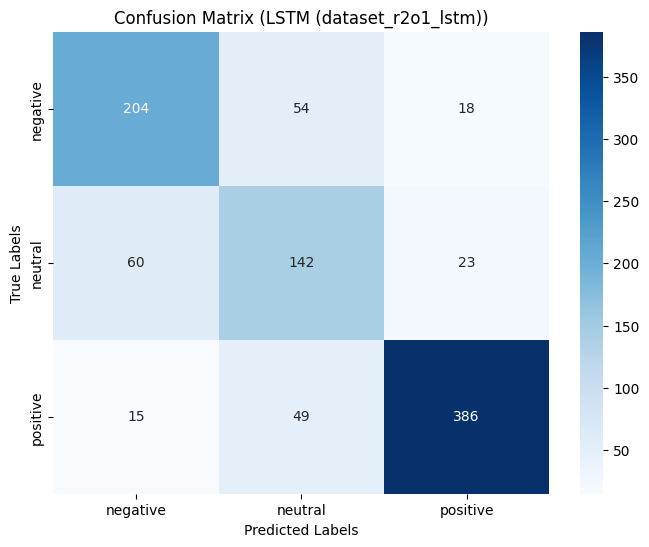

In [ ]:
# Train and evaluate on `dataset_r2o1_lstm`
#class_weights_dict_r2o1_lstm = {0: 1.1492, 1: 1.4086, 2: 0.7043} # opt_03 modified {0: 5.0203, 1: 4.3374, 2: 0.3891}=>{0: 6.0, 1: 5.5, 2: 0.4}
print("\nTraining on `dataset_r2o1_lstm`...")
lstm_model_r2o1_lstm = train_lstm_model(X_train_r2o1_lstm, y_train_r2o1_lstm_onehot, X_val_r2o1_lstm, y_val_r2o1_lstm_onehot, class_weights_dict_r2o1_lstm, "LSTM (dataset_r2o1_lstm)")

print("\nEvaluating on `dataset_r2o1_lstm`...")
#evaluate_lstm_model(lstm_model_r2o1_lstm, X_test_r2o1_lstm, y_test_r2o1_lstm_onehot, "LSTM (dataset_r2o1_lstm)")
target_names_r2o1 = ["negative", "neutral", "positive"]  # Class names for 3 labels
evaluate_lstm_model(
    lstm_model_r2o1_lstm,
    X_test_r2o1_lstm,
    y_test_r2o1_lstm_onehot,
    "LSTM (dataset_r2o1_lstm)",
    target_names=target_names_r2o1
)
